In [17]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
from glob import glob as glob
import os
from neo import io
import seaborn as sb
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"
from sklearn.metrics import roc_auc_score

# functions 
from skimage.measure import label

def clustertest(true,permutations,thresh):
    nperm = permutations.shape[-1]
    t_val = abs((true - np.mean(permutations,-1)) / np.std(permutations,-1)) # 2-sided
    above_threshold = t_val>thresh
    sig_clust = label(above_threshold)
    clust_sum = np.zeros(np.max(sig_clust))
    for c in range(1,max(sig_clust)+1):
        
        clust_sum[c-1] = np.sum(t_val[sig_clust==c])
    # get random clusters
    clust_sum_rand = np.zeros(nperm)
    for perm in range(nperm):
        compare_to = np.delete(permutations,perm,axis=-1)
        t_val = abs((permutations[:,perm] - np.mean(compare_to,-1)) / np.std(compare_to,-1))
        above_threshold = t_val>thresh
        sig_clust_rand = label(above_threshold)
        if np.max(sig_clust_rand)>0:
            clust_sum_r = np.zeros(np.max(sig_clust_rand))
            for c in range(1,max(sig_clust_rand)+1):
                clust_sum_r[c-1] = np.sum(t_val[sig_clust_rand==c])
            clust_sum_rand[perm] = np.max(clust_sum_r)
    # compard random and true
    P = np.zeros(true.shape)*np.nan
    for c in range(len(clust_sum)):
        P[sig_clust==c+1] = np.mean(clust_sum[c]<=clust_sum_rand)
    return P

def getAUROC(true,pred):
    ''' compute AUC of classifier for a temporal generalization matrix 
    pred is a matrix of shape ntrials x nbins x nbins'''
    if len(pred.shape)==3:
        # AUC time x time matrix
        nbins = pred.shape[1]
        AUC = np.zeros((nbins,nbins))
        for b in range(nbins):
            for b2 in range(nbins):
                AUC[b,b2] = roc_auc_score(true,pred[:,b,b2])
    elif len(pred.shape)==2:
        nbins = pred.shape[1]
        AUC = np.zeros(nbins)
        for b in range(nbins):
            if len(true.shape)>1:
                AUC[b] = roc_auc_score(true[:,b],pred[:,b])
            else:
                AUC[b] = roc_auc_score(true,pred[:,b])
    elif len(pred.shape)==1:
        AUC = roc_auc_score(true,pred)
    return AUC


def designMatrix(globdev,local,stimulus=None,include_stim=False):
    '''
    design matrix of nsamples x nvariables
    Variables are: Stimulus, Local deviance, Global deviance, Blocktype (xx or xY)'''
    
    ntr = len(local)
    loc = local.copy();
    glob = globdev.copy()
    if include_stim:
        stim = stimulus.copy()
        X = np.vstack((loc,glob,stim,np.ones(ntr))).astype(float).T
    else:
        X = np.vstack((loc,glob,np.ones(ntr))).astype(float).T
        
    return X

def designMatrix_first3(blocks,stimulus):
    '''
    design matrix of nsamples x nvariables
    Variables are: Stimulus, Local deviance, Global deviance, Blocktype (xx or xY)'''
    
    ntr = len(blocks)
    context = blocks.copy()
    stim = stimulus.copy()
    X = np.vstack((context,stim,np.ones(ntr))).astype(float).T
    return X

def projectMUA(Coef,Y,Sess,Testtrials,compute_matrix = False):
    '''
    Projection of binned population MUA onto coefficient vector from 
    multivariate linear regression with cross-validation
    Projection onto single coefficient vector
    '''
    ntr,nch,nbins = Y.shape
    nsess = len(np.unique(Sess))
    nvar = Coef.shape[1]   
    
    Proj = np.zeros((nsess,nvar,ntr,nbins))# pre-allocate
    # project individual trials
    # use hold-out data per fold
    K = Coef.shape[-1]
    for sess in range(nsess):
        print('Session %s'%(sess+1))
        sessind = np.where(Sess==sess)[0] # trial indices from session
        Ysess = Y[sessind,:] # MUA from session
        
        proj = np.zeros((nvar,len(sessind),nbins))
        for k in range(K): 
            test_ind = Testtrials[sess][k]
            # projection onto coefficients from each bin
            coef = preprocessing.normalize(Coef[sess,:,:,k],norm='l2',axis=1)
            for b in range(nbins):
                
                # project all bins onto this axis 
                proj[:,test_ind,b] = coef@Ysess[test_ind,:,b].T
                        
                # get inter-session projection, only for one fold
                if k==0:
                    Proj[sess,:][:,Sess!=sess,b] = coef@Y[Sess!=sess,:,b].T
            
        Proj[sess,:][:,sessind,:] = proj
        
    return Proj

def projectMUA_cv(Coef,Y,Sess,Testtrials,compute_matrix = False):
    '''
    Projection of binned population MUA onto coefficient vector from 
    multivariate linear regression with cross-validation
    compute_matrix: 
    '''
    nbins_train = Coef.shape[-2]
    ntr,nch,nbins = Y.shape
    nsess = len(np.unique(Sess))
    nvar = Coef.shape[1]   
    if compute_matrix == True:
        Proj = np.zeros((nsess,nvar,ntr,nbins_train,nbins))# pre-allocate
    else:
        Proj = np.zeros((nsess,nvar,ntr,nbins_train))# pre-allocate
    # project individual trials
    # use hold-out data per fold
    K = Coef.shape[-1]
    for sess in range(nsess):
        print('Session %s'%(sess+1))
        sessind = np.where(Sess==sess)[0] # trial indices from session
        Ysess = Y[sessind,:] # MUA from session
        
        if compute_matrix == True:
            proj = np.zeros((nvar,len(sessind),nbins_train,nbins))
        else:
            proj = np.zeros((nvar,len(sessind),nbins_train))
        for k in range(K): 
            test_ind = Testtrials[sess][k]
            # projection onto coefficients from each bin
            for b in range(nbins_train):
                coef = preprocessing.normalize(Coef[sess,:,:,b,k],norm='l2',axis=1)

                # project all bins onto these axes (temporal generalization matrix)
                if compute_matrix == True:
                    for btest in range(nbins):
                        proj[:,test_ind,b,btest] = coef@Ysess[test_ind,:,btest].T
                        
                        # get inter-session projection, only for one fold
                        if k==0:
                            Proj[sess,:][:,Sess!=sess,b,btest] = coef@Y[Sess!=sess,:,btest].T
                # project only same bin as training
                else:
                    proj[:,test_ind,b] = coef@Ysess[test_ind,:,b].T
                        
                    # get inter-session projection, only for one fold
                    if k==0:
                        Proj[sess,:][:,Sess!=sess,b] = coef@Y[Sess!=sess,:,b].T
            
        Proj[sess,:][:,sessind,:] = proj
        
    return Proj


def balance_data(Xtrain, train_ind,include_stim):
    '''balance classes in data'''
    N = []
    if include_stim:
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                for l,v3 in enumerate(np.unique(Xtrain)):
                # count trials of condition
                    n = sum((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2) & (Xtrain[:,3]==v3))
                    N.append(n)
        nmin = np.min(N)
        # subsample
        keep_ind = []
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                for l,v3 in enumerate(np.unique(Xtrain)):
                    # count trials of condition
                    condind = np.where((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2) & (Xtrain[:,3]==v3))[0] #balance local, global, stimulus
                    keep_ind.extend(condind[np.random.permutation(len(condind))[:nmin]])
    else:
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                # count trials of condition
                n = sum((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2))
                N.append(n)
        nmin = np.min(N)
        # subsample
        keep_ind = []
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                # count trials of condition
                condind = np.where((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2))[0] #balance local, global, stimulus
                keep_ind.extend(condind[np.random.permutation(len(condind))[:nmin]])
    train_ind = train_ind[keep_ind]
    return train_ind



Load preprocessed data and extract sequence variables

In [3]:
# parameters
animal_id = 'A11' # A11, H07
exp = 'classical' # 'wang or classical
out_path = '/Volumes/Bellet/Local_Global/processedData/%s/'%animal_id # path to the data

# load preprocessed data
df = pd.read_pickle(os.path.join(out_path,'%s_stims_spikes_dataframe.pkl'%(animal_id)))

# extract basic variables
dates = np.unique(df.date)
ndates = len(dates)
nitems = np.max(df.ItemID)
stimID = np.unique(df.StimID)
nstim = len(stimID)
print(list(df.keys()))
print('Recording dates:',dates)

soa = 600
Local = []
Global = []
BlockID = []
Blocktype = []
Block = [] # which block
Include = []
Stimon = []
SessionDate = []
StimID = []
sess = 0
blocks = ['aa','aB','bb','bA'] # coded like this in the experiment
for d,date in enumerate(dates):


    
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        SessionDate.append(date)
        Local.append(np.zeros(Ntrials).astype(int))
        for i,ind in enumerate(last_item):
            if df.StimID.iloc[ind]!=df.StimID.iloc[ind-1]: # local deviant = transition of two stim
                Local[sess][i] = 1
        
        BlockID.append(np.array(df.blockID[last_item])) # blockID
        Block.append(np.array(df.blockType[last_item])) # which block (classical experiment: 0,1,2 or 3)
        Blocktype.append(np.zeros(Ntrials).astype(int)) # xx=0 xY=1
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Blocktype[sess][ind] = Local[sess][ind[0]] # blocktype defined by the first habituation trial in block
        
        Global.append((Local[sess]!=Blocktype[sess]).astype(int))
        
        # filter habituation trials
        nhab = 50
        Include.append(np.ones(len(Global[sess])).astype(int))
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Include[sess][ind[:nhab]] = 0
            
        Stimon.append(np.array(df.StimOn.iloc[last_item])) # last stim onset times
        StimID.append(np.array(df.StimID.iloc[last_item]))

        
        sess += 1
    
Session = np.concatenate([np.ones(len(Local[i]))*i for i in range(len(Local))])
Local = np.concatenate(Local)
Global = np.concatenate(Global)
Blocktype = np.concatenate(Blocktype)
Block = np.concatenate(Block)
Include = np.concatenate(Include)
StimID = np.concatenate(StimID)

['PFC_MU', 'PPC_MU', 'PFC_SU', 'PPC_SU', 'TrialID', 'ItemID', 'StimID', 'StimName', 'StimOn', 'blockID', 'blockType', 'date', 'StimDur', 'ISIDur', 'RewardOn']
Recording dates: ['20200226' '20200228' '20200305' '20200306' '20200311' '20200312']
Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


### AUC context (blocktype) on global axis

In [21]:
## first project entire sequence on local or global axis
bins_around = 5 # how many bins to include pre and post max. decoding performance bin
nperm = 100
K = 10

# get MUA
MUA = []
sess = 0
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb_last = np.load(os.path.join(out_path,'Rb_last_gauss_%s.npy'%date))
        Rb = np.load(os.path.join(out_path,'Rb_seq_gauss_%s.npy'%date))
        time_bins = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%date))
        
        _,nch,nbins = Rb.shape
        # centre each channel
        Rc = Rb.copy()
        for ch in range(nch):
            Rc[:,ch,:] = (Rb[:,ch,:] - np.mean(Rb_last[:,ch,:])) / (np.std(Rb_last[:,ch,:]) + 10e-6) # centre each channel
        MUA.append(Rc)    
        
        
        sess += 1
        
del Rb, Rc

nbins = len(time_bins)

# load coefficients
Coef = np.load(os.path.join(out_path,'Coef_last_%s_%s.npy'%(exp,soa)))
# load AUC of last item and get bin of maximum performance on the diagonal
AUC_glob = np.load(os.path.join(out_path,'AUC_Global_last_True_classical_600.npy'))
maxbin_glob = np.argmax(np.mean(np.diagonal(np.diagonal(AUC_glob,axis1=0,axis2=1),axis1=1,axis2=2)[0,:],0))
GlobCoef = np.mean(Coef[:,1,:,maxbin_glob-bins_around:maxbin_glob+bins_around+1,:],2)

# load test folds:
Folds = []
for i,d in enumerate(dates):
    Folds_dict = np.load(os.path.join(out_path,'Testfolds_%s_last_classical_600.npy'%(d)),allow_pickle=True).item()
    Folds.append([])
    for j in range(K):
        Folds[i].append(Folds_dict[j])
nsess = len(MUA)        

# Projections
AUC_glob_block = np.zeros((nbins))
RandAUC_glob_block = np.zeros((nbins,nperm))
Proj_glob_all = []
for sess,date in enumerate(dates):
    # project MUA on axes within each recording session
    Rc = MUA[sess][Include[Session==sess]==1,:]
    ntr = Rc.shape[0]
    Proj_glob = np.zeros((ntr,nbins))
    for k in range(K):
        test_ind = Folds[sess][k]
        
        # normalize coefficient vector:
        coef_glob = preprocessing.normalize(GlobCoef[sess,:,k].reshape(-1, 1),norm='l2')
        for b in range(nbins):
            Proj_glob[test_ind,b] = coef_glob[:,0]@Rc[test_ind,:,b].T
    Proj_glob_all.extend(Proj_glob)        
# compute AUC from projections
Proj_glob_all_arr = np.array(Proj_glob_all)    
ind = Global[:-1][Include[1:]]==0
    
AUC_glob_block = getAUROC(Blocktype[1:][Include[1:]==1][ind].astype(float),Proj_glob_all_arr[1:,:][ind,:])
for perm in range(nperm): # permutations for diagonal of temp gen matrix only
    randind = np.random.permutation(sum(ind))
    
    RandAUC_glob_block[:,perm] = getAUROC(Blocktype[1:][Include[1:]==1][ind][randind].astype(float),Proj_glob_all_arr[1:,:][ind,:])              
    
AUC_glob_block[np.argmin(abs(time_bins - 3*soa/1000)):] = np.nan
RandAUC_glob_block[np.argmin(abs(time_bins - 3*soa/1000)):,:] = np.nan

threshold = 3
alpha = .01

time_bins = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%date))
time_bins_last = np.load(os.path.join(out_path,'time_bins_gauss_%s.npy'%date))
binsize = np.mean(np.diff(time_bins))

t_sub = time_bins_last[maxbin_glob-bins_around:maxbin_glob+bins_around+1] + 3*soa/1000

# plot trajectories
colors = [['#229eba','#48e5ca'], # local standards
         ['#f4884d','#f2dd20']] # local deviants
plt.figure(figsize=(3,3))
for c1 in range(2):
    for c2 in range(2):
        ind = (Global[Include==1][1:]==c2) & (Local[Include==1][1:]==c1) & (Global[Include==1][:-1]==0)
        av = np.mean(Proj_glob_all_arr[1:,:][ind,:],0)
        sem = np.std(Proj_glob_all_arr[1:,:][ind,:],0)/np.sqrt(sum(ind))
        plt.plot(time_bins+binsize,av,label='Local %s, Global %s'%(c1,c2),color=colors[c1][c2])
        plt.fill_between(time_bins+binsize,av-sem,av+sem,alpha=.2,color=colors[c1][c2],linewidth=0)
# plot decoding window
ymin,ymax = plt.ylim()
plt.fill_between(t_sub,ymin*np.ones(len(t_sub)),ymax*np.ones(len(t_sub)),color='k',alpha=.1,linewidth=0)
sb.despine(trim=True)
plt.tight_layout()
plt.savefig(os.path.join(out_path,'plots','Projections_Late_Global_%s_%s.pdf'%(exp,soa)),bbox_inches='tight')
plt.show()


fig,ax = plt.subplots(2,1,figsize=(3,4),sharex=True)

# plot AUC
m = AUC_glob_block
ax[1].plot(time_bins+binsize,m,'k',linewidth=1)
ymin,ymax = ax[1].get_ylim()
for i in range(4):
    ax[1].fill_between(np.linspace(i*soa/1000,i*soa/1000+soa/1000/2,2),
                        np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)

# stats
p = clustertest(AUC_glob_block,RandAUC_glob_block,threshold)

# stats:
l = label(~np.isnan(p))
ymin,ymax = ax[1].get_ylim()
for j in np.unique(l):
    if p[l==j][0]<=alpha:
        print(p[l==j][0])
        ax[1].plot(time_bins[l==j]+binsize,np.ones(sum(l==j))*ymax,color='k',linewidth=1.5)


for c1 in range(2):
    for c2 in range(2):
        ind = (Global[Include==1][1:]==c2) & (Local[Include==1][1:]==c1) & (Global[Include==1][:-1]==0)
        av = np.mean(Proj_glob_all_arr[1:,:][ind,:],0)[:int((soa/1000*3-binsize-.05)/binsize)]
        sem = np.std(Proj_glob_all_arr[1:,:][ind,:],0)[:int((soa/1000*3-binsize-.05)/binsize)]/np.sqrt(sum(ind))
        ax[0].plot(time_bins[:int((soa/1000*3-binsize-.05)/binsize)]+binsize,av,
                   label='Local %s, Global %s'%(c1,c2),color=colors[c1][c2])
        ax[0].fill_between(time_bins[:int((soa/1000*3-binsize-.05)/binsize)]+binsize,av-sem,av+sem,alpha=.2,color=colors[c1][c2],linewidth=0)
ax[1].set_xlim(-soa/2/1000+binsize,soa/1000*3-binsize-.05)
plt.xlabel('Time from sequence onset')
ax[1].set_ylabel('Blocktype AUROC')
ax[1].set_ylim(None,.6)
ax[1].set_yticks((.5,.6))
ax[1].plot(time_bins+binsize,np.ones(nbins)*.5,'k--',linewidth=1)
sb.despine()
plt.tight_layout()
sb.despine(trim=True)
#plt.savefig(os.path.join(out_path,'plots','AUC_Blocktype_Global_%s_%s.pdf'%(exp,soa)))
plt.show()
plt.show()

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4485 but corresponding boolean dimension is 5734

### Learning during habituation

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312
P xx =  0.002693091698179759
P xy =  0.04141199870158438


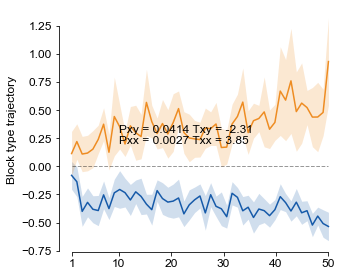

In [9]:
Coef = np.load(os.path.join(out_path,'Coef_first3_classical_600.npy')) # load coefficients of glob axis

from scipy.stats import ranksums,ttest_rel
# get global deviance response on every trial during habituation
block_ax = 0
nhab = 50

# time vectors
time_bins = np.load(os.path.join(out_path,'time_bins_gauss_%s.npy'%dates[0])) # time vector
time_bins_seq = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%dates[0])) # time vector
binsize = np.round(np.mean(np.diff(time_bins)),3)
time_bins = time_bins + binsize

# load PSTH per session
MUA = []
sess = 0
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_gauss_%s.npy'%date))
        
        ntr,nch,nbins = Rb.shape
        # centre each channel
        Rc = Rb.copy()
        for ch in range(nch):
            Rc[:,ch,:] = (Rb[:,ch,:] - np.mean(Rb[:,ch,:])) / (np.std(Rb[:,ch,:]) + 10e-6) # centre each channel
        MUA.append(Rc)
        
        sess += 1
        
del Rb, Rc
MUA = np.concatenate(MUA)
nbins = len(time_bins_seq)
nsess = len(dates)
K = Coef.shape[-1]
Proj = np.zeros((nsess,4,nhab,nbins,K)) # shape is sessions x blocks x trials x bins
for sess in range(nsess):
    coef = Coef[sess,block_ax,:]
    for bl in range(4): # separately for each block in session
        ind = np.where((Session==sess) & (Block==bl))[0][:nhab]
        # project those trials onto global axis
        for b in range(nbins):
            for k in range(K):
                Proj[sess,bl,:,b,k] = coef[:,k]@MUA[ind,:,b].T
          

    # PLOT
# which bins to average:
soa = .6 # sec
binsize = np.round(np.mean(np.diff(time_bins_seq)),3)
b_start_glob = int(np.round((abs(time_bins_seq[0]) + 0)/binsize))
b_end_glob = int(np.round((abs(time_bins_seq[0]) + 3*soa - .2)/binsize)) # until 3d stim + soa - .2

Proj_cv_av = np.mean(Proj,-1) # average across cv folds

window = 1
proj_xx = np.reshape(Proj_cv_av[:,[0,2],:],(nsess*2,nhab,nbins))
proj_xx = np.mean(proj_xx[:,:,b_start_glob:b_end_glob],-1)
proj_xx_smooth = np.array([np.mean(proj_xx[:,i:i+window],1) for i in range(1,int(nhab-window))])
proj_xx_smooth = np.concatenate((proj_xx[:,0:1].T,proj_xx_smooth),axis=0)
blocks_xx = np.repeat(np.array([0,2])[np.newaxis,:],nsess,axis=0) # block label
blocks_xx = np.reshape(blocks_xx,(nsess*2))

proj_xy = np.reshape(Proj_cv_av[:,[1,3],:],(nsess*2,nhab,nbins))
proj_xy = np.mean(proj_xy[:,:,b_start_glob:b_end_glob],-1)
proj_xy_smooth = np.array([np.mean(proj_xy[:,i:i+window],1) for i in range(1,int(nhab-window))])
proj_xy_smooth = np.concatenate((proj_xy[:,0:1].T,proj_xy_smooth),axis=0)
blocks_xy = np.repeat(np.array([1,3])[np.newaxis,:],nsess,axis=0) # block label
blocks_xy = np.reshape(blocks_xy,(nsess*2))

v = np.linspace(window+1,nhab,proj_xx_smooth.shape[0]-1)
v = np.concatenate((np.ones(1),v))

T_xx,P_xx = ttest_rel(proj_xx_smooth[0,:],proj_xx_smooth[-1,:])
T_xy,P_xy = ttest_rel(proj_xy_smooth[0,:],proj_xy_smooth[-1,:])
print('P xx = ',P_xx)
print('P xy = ',P_xy)
    
# PLOT
# plot xx
plt.figure(figsize=(5,4))
av_xx = np.mean(proj_xx_smooth,1)
sem_xx = np.std(proj_xx_smooth,1)/np.sqrt(nsess*2)
plt.fill_between(v,av_xx-sem_xx,av_xx+sem_xx,color='#165aa9',alpha=.2,linewidth=0)
plt.plot(v,av_xx,color='#165aa9')
plt.annotate('Pxx = %s Txx = %s'%(np.round(P_xx,4),np.round(T_xx,2)),xy=(10,.2))

# plot xY
av_xy = np.mean(proj_xy_smooth,1)
sem_xy = np.std(proj_xy_smooth,1)/np.sqrt(nsess*2)
plt.fill_between(v,av_xy-sem_xy,av_xy+sem_xy,color='#ee8c22',alpha=.2,linewidth=0)
plt.plot(v,av_xy,color='#ee8c22')
plt.annotate('Pxy = %s Txy = %s'%(np.round(P_xy,4),np.round(T_xy,2)),xy=(10,.3))

plt.plot(v,np.zeros(len(v)),'k--',linewidth=1,alpha=.4)
plt.xticks([1,10,20,30,40,50])
sb.despine(trim=True)
plt.ylabel('Block type trajectory')
plt.tight_layout()
#plt.savefig(os.path.join(out_path,'plots','LearningBlock_%s_%s.pdf'%(exp,soa)))
plt.show()

### Blocktype effect for matched trials and post-global deviant

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=

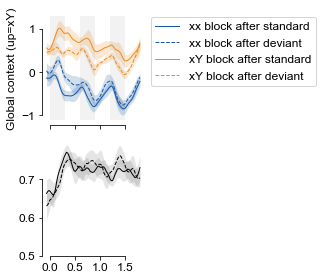

In [20]:
time_bins_seq = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%dates[0])) # time vector whole seq 
Proj_first3 = np.load(os.path.join(out_path,'Proj_first3_%s_%s.npy'%(exp,soa)))
# plot block type effect for matched trials (precedet by xY or xx) in xY or xx blocks
# for xY trials, get local deviance response and blocktype response in following trial
nperm = 0
nsess = len(np.unique(Session))

last_stim_on = np.argmin(abs(time_bins_seq-3*.6))
nbins = last_stim_on
Proj_block = np.zeros((nsess,2,2,nbins))

block_ax = 0 # which dimensions in projection matrix to use
AUC = np.zeros((nsess,2,nbins))
RandAUC = np.zeros((nsess,2,nbins,nperm))
AUCdev = np.zeros((nsess,2,nbins))
RandAUCdev = np.zeros((nsess,2,nbins,nperm))


for sess in range(nsess):
    # store trials to compute AUC later
    AllProj_block = [[],[]]
    AllBlock = [[],[]]
    for c in range(2): # xx or xy block
        for c2 in range(2): # previous trial xx or xY
            # complicated because only should include trials preced by a completed trial within the same block
            last_item = np.where((df.ItemID==3) & (df.date==dates[sess]) )[0]
            previous_trial_completed = (df.ItemID.iloc[last_item-4]==3)
            previous_trial_same_block = np.array(df.blockType.iloc[last_item-4])==np.array(df.blockType.iloc[last_item])
            
            # choose block of current trial and local deviance of previous trial
            trial_block = Blocktype[Session==sess]==c
            
            # apply all criteria
            inc = np.array((trial_block[1:]) & (Local[Session==sess][:-1]==c2) & previous_trial_completed[1:]  & previous_trial_same_block[1:]  & (Include[Session==sess][:-1]==1))
            inc = inc[Include[Session==sess][1:]==1]
            inc = np.where(np.concatenate((np.zeros(1).astype(int),inc)))[0] - 1            
            #average
            Proj_block[sess,c,c2,:] = np.mean(Proj_first3[sess,block_ax,(Session[Include==1]==sess),:][inc,:last_stim_on],0)
            # all trials
            AllProj_block[c2].append(Proj_first3[sess,block_ax,(Session[Include==1]==sess),:][inc,:last_stim_on])
            AllBlock[c2].extend(c*np.ones(len(inc)))
            

    # compute AUC
    for c2 in range(2):  # previous trial xx or xY
        AUC[sess,c2,:] = getAUROC(np.array(AllBlock[c2]).astype(float),np.concatenate(AllProj_block[c2]))
        # random permutations
        for perm in range(nperm):
            randind = np.random.permutation(len(AllBlock[c2]))
            RandAUC[sess,c2,:,perm] = getAUROC(np.array(AllBlock[c2]).astype(float)[randind],np.concatenate(AllProj_block[c2]))
    
# 1. plot trajectories from above but for same global context, different global deviance condition in previous trial
threshold = 3
alpha = 0.05

colors = ['#165aa9','#ee8c22'] # block type colors
ls = ['-','--'] # standard or deviant before
labels = [['xx block after standard','xx block after deviant'],['xY block after standard','xY block after deviant']]
binsize = np.mean(np.diff(time_bins_seq))

fig,ax = plt.subplots(2,1,figsize=(4.5,4),sharex=True)

# PLOT PROBABILITY
for c in range(2): # xx or xy block 
    for c2 in range(2): # previous trial standard or dev
        av = np.mean(Proj_block[:,c,abs(c2-1*c),:],0)
        sem = np.std(Proj_block[:,c,abs(c2-1*c),:],0)/np.sqrt(nsess)
        
        ax[0].fill_between(time_bins_seq[:last_stim_on]+binsize,av-sem,av+sem,alpha=.2,linewidth=0,color=colors[c])
        ax[0].plot(time_bins_seq[:last_stim_on]+binsize,av,color=colors[c],linewidth=1,linestyle=ls[c2],label=labels[c][c2])
ymin,ymax = ax[0].get_ylim()
ax[0].legend(bbox_to_anchor=(1,1))
for i in range(3):
    ax[0].fill_between(np.linspace(i*.6,i*.6+.6/2,2),
                               np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)

    
# PLOT AUC BLOCK TYPE, MATCHED IN LOCAL PRE
labels = ['preceded by xx','preceded by xY']
for c2 in range(2): # previous trial xx or xY
    av = np.mean(AUC[:,c2,:],0)
    randav = np.mean(RandAUC[:,c2,:],0)
    sem = np.std(AUC[:,c2,:],0)/np.sqrt(nsess)
        
    ax[1].fill_between(time_bins_seq[:last_stim_on]+binsize,av-sem,av+sem,alpha=.1,linewidth=0,color='k')
    ax[1].plot(time_bins_seq[:last_stim_on]+binsize,av,color='k',linewidth=1,linestyle=ls[c2],label=labels[c2])
    # stats:
    p = clustertest(av,randav,threshold)
    l = label(~np.isnan(p))
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            print(p[l==j][0])
            ax[1].plot(time_bins_seq[:last_stim_on][l==j]+binsize,np.ones(sum(l==j))*.6+.06*c2,color='k',
                       linestyle = ls[c2],linewidth=1.5)
            
    ax[1].set_ylim(.5,None)

sb.despine(trim=True)
plt.tight_layout()
ax[0].set_ylabel('Global context (up=xY)')
#ax[2].set_ylabel('Effect of preceding global deviant (context AUROC)')
#plt.savefig(os.path.join('plots','Context_BlockMatched_%s_%s_%s.pdf'%(exp,soa,animal_id)))
plt.show()

### Effect of distance from global deviant

Ttest_relResult(statistic=2.3641092260419474, pvalue=0.01855779827187455)
Ttest_relResult(statistic=-0.2352891859978196, pvalue=0.8141065301474748)
Ttest_relResult(statistic=-1.5049951256765712, pvalue=0.1331265390401334)
Ttest_relResult(statistic=-5.02123687109009, pvalue=7.575394870271354e-07)
Ttest_relResult(statistic=-1.7728522760517513, pvalue=0.07697108177697776)
Ttest_relResult(statistic=-0.06299914097394924, pvalue=0.9497968761999898)


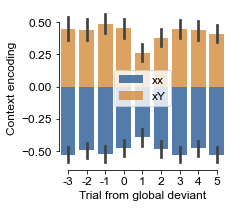

In [22]:
# get all global deviant trials and plot average global context response as a function of the distance from the global deviant trials
trials_around = np.arange(-3,6)
# selectrion criteria: global deviant trial and next 5 trials in same session & same block

glob_criterion = Global[Include==1][abs(trials_around[0]):-trials_around[-1]]==1
noglob_criterion = glob_criterion.copy()# check if no global deviants around
for shift in trials_around:
    if shift==0:
        continue
    elif shift<trials_around[-1]:
        noglob_criterion = (noglob_criterion==1) & (Global[Include==1][abs(trials_around[0])+shift:-trials_around[-1]+shift]==0)
    else:
        noglob_criterion = (noglob_criterion==1) & (Global[Include==1][abs(trials_around[0])+shift:]==0)


block_criterion = Blocktype[Include==1][:-trials_around[-1]+trials_around[0]] == Blocktype[Include==1][abs(trials_around[0])+trials_around[-1]:]
sess_criterion = Session[Include==1][:-trials_around[-1]+trials_around[0]] == Session[Include==1][abs(trials_around[0])+trials_around[-1]:]
block = Blocktype[Include==1][abs(trials_around[0]):-trials_around[-1]]
session = Session[Include==1][abs(trials_around[0]):-trials_around[-1]]
proj = Proj_first3[:,block_ax,:][:,:,int(abs(time_bins_seq[0])/binsize):last_stim_on]

resp = [[],[]]
for bl in range(2): # loop across contexts
    for sess in range(nsess):
        resp[bl].append([])
        criterion = np.where(glob_criterion & block_criterion & sess_criterion & (block==bl) & (session==sess))[0]
        criterion = criterion + abs(trials_around[0])
        for i,shift in enumerate(trials_around):
            av_resp = np.mean(proj[sess,criterion+shift,:],-1)
            resp[bl][sess].append(av_resp)
            
# pool sessions
context_resp = [[],[]]
for bl in range(2):
    for sess in range(nsess):
        context_resp[bl].extend(np.array(resp[bl][sess]).T)

        
import scipy.stats as stats

# STATS
# ANOVA with variables trial number, block

labels = ['xx','xY']
fig,ax = plt.subplots(1,1,figsize=(3,3),sharey=True)
colors = ['#165aa9','#ee8c22'] # block type colors
for c in range(2):
    
    r = np.array(context_resp[c])
    # ANOVA for each block type

    #st = stats.f_oneway(r[:,3],
    #           r[:,4],
    #           r[:,5],
    #           r[:,6],
    #           r[:,7],
    #           r[:,8],)
    #print(st)
    # pairwise t-test
    for i in range(3):
        T = stats.ttest_rel(r[:,np.where(trials_around==1+i)[0][0]],r[:,np.where(trials_around==0)[0][0]])
        print(T)
    # PLOT
    ctx_df = pd.DataFrame(r,columns=trials_around)
    #av = abs(np.mean(r,0))
    #sem = np.std(r,0)/np.sqrt(r.shape[0])
    sb.barplot(data=ctx_df,linewidth=1,label=labels[c],color=colors[c],ax=ax,alpha=.8)
    #plt.fill_between(trials_around,av-sem,av+sem,alpha=.1,linewidth=0)
ymin,ymax = plt.ylim()
plt.xlabel('Trial from global deviant')
plt.legend()
ax.set_ylabel('Context encoding')
sb.despine(trim=True)
#plt.savefig(os.path.join(out_path,'plots','EffectOfDeviantOntoContext_%s_%s.pdf'%(exp,soa)))
plt.show()